<a href="https://colab.research.google.com/github/mridul-eecs/Image-Similarity-Recommendation-System/blob/master/imagesimilarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!rm -r ~/.kaggle;mkdir ~/.kaggle
!cp drive/My\ Drive/kaggle.json /root/.kaggle  

rm: cannot remove '/root/.kaggle': No such file or directory


In [11]:
!kaggle datasets download -d paramaggarwal/fashion-product-images-small

 98% 553M/565M [00:13<00:00, 32.7MB/s]
100% 565M/565M [00:13<00:00, 44.8MB/s]


In [2]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import pairwise_distances
import pandas as pd
import random
import os
from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
model = applications.xception.Xception(weights='imagenet', include_top=False, pooling='avg')

83689472/83683744 [==============================] - 2s 0us/step


In [0]:
model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [0]:
# !mkdir data
!unzip -qq fashion-product-images-small.zip 

44441


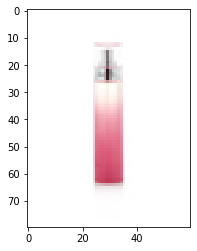

In [16]:
data= os.listdir('images')
datalen= len(data)
print(datalen)
plt.imshow(plt.imread('images/{}'.format(data[0])))
plt.show()

In [17]:
# train_test spliting data
!mkdir testdata
testdata= random.choices(data, k= int(datalen * 0.2))
print(len(testdata))
for sample in tqdm(testdata):
  os.system("mv images/{} testdata/".format(sample))

mkdir: cannot create directory ‘testdata’: File exists
8888


In [18]:
listoffiles= os.listdir('images/')
testsamples= int(len(listoffiles) * 0.2) #taking 20% images for testing
samples= random.choices(listoffiles, k= testsamples)
!mkdir testdata
for s in samples:
  os.system("mv {basedir}{s} testdata")


mkdir: cannot create directory ‘testdata’: File exists


In [0]:
!mkdir data
!mv images data


In [0]:
def save_bottleneck_features(modelname):
  filenames= []
  datagen= ImageDataGenerator(rescale= 1./255)
  generator= datagen.flow_from_directory('data',
                                        target_size= (224, 224),
                                        batch_size= 512,
                                        class_mode= None,
                                        shuffle= False,
                                        classes= None)
  
  print(len(generator.filenames))
  bottleneck_features_train = model.predict_generator(generator, verbose= 1)
  print(np.shape(np.array(bottleneck_features_train)))

  np.save(open('drive/My Drive/imagesimilarity/cnn_features_filenames_{}.npy'.format(modelname), 'wb'), np.array(generator.filenames))
  np.save(open('drive/My Drive/imagesimilarity/cnn_features_features_{}.npy'.format(modelname), 'wb'), np.array(bottleneck_features_train))
  

save_bottleneck_features('xception')


Found 36370 images belonging to 1 classes.
36370
72/72 [==============================] - 103s 1s/step
(36370, 2048)


In [3]:
# loading extracted features
filenames= np.load('drive/My Drive/imagesimilarity/cnn_features_filenames_xception.npy')
features= np.load('drive/My Drive/imagesimilarity/cnn_features_features_xception.npy')

filenames

array(['images/10000.jpg', 'images/10001.jpg', 'images/10002.jpg', ...,
       'images/9997.jpg', 'images/9998.jpg', 'images/9999.jpg'],
      dtype='<U16')

In [14]:
# checking sparcity of this matrix
import scipy
s_features = scipy.sparse.csr_matrix(features) 
print(s_features.count_nonzero()/features.size)
# the matrix is not sparse hence this will not work in speeding up process

0.6625708457562896


In [24]:
df_features= pd.DataFrame(features, index= filenames)
cosine_sim = 1-pairwise_distances(df_features, metric= "cosine")
cosine_sim

array([[0.9999999 , 0.6353076 , 0.564072  , ..., 0.4609831 , 0.41384256,
        0.5225326 ],
       [0.6353076 , 1.        , 0.69876534, ..., 0.44115132, 0.39125574,
        0.50976753],
       [0.564072  , 0.69876534, 0.9999999 , ..., 0.4171822 , 0.38371867,
        0.49522644],
       ...,
       [0.4609831 , 0.44115132, 0.4171822 , ..., 1.        , 0.7235875 ,
        0.6414671 ],
       [0.41384256, 0.39125574, 0.38371867, ..., 0.7235875 , 0.9999998 ,
        0.6122004 ],
       [0.5225326 , 0.50976753, 0.49522644, ..., 0.6414671 , 0.6122004 ,
        0.9999999 ]], dtype=float32)

In [25]:
# similarity dataframe
df_sim= pd.DataFrame(cosine_sim, index= filenames)
df_sim.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,36330,36331,36332,36333,36334,36335,36336,36337,36338,36339,36340,36341,36342,36343,36344,36345,36346,36347,36348,36349,36350,36351,36352,36353,36354,36355,36356,36357,36358,36359,36360,36361,36362,36363,36364,36365,36366,36367,36368,36369
images/10000.jpg,1.000000,0.635308,0.564072,0.566962,0.463975,0.403088,0.339699,0.349368,0.409783,0.380030,0.323164,0.392158,0.491140,0.534495,0.506473,0.320394,0.302067,0.536349,0.442914,0.326291,0.428072,0.426591,0.435093,0.289047,0.316208,0.311187,0.370390,0.412954,0.315203,0.370381,0.509782,0.434821,0.375012,0.392599,0.382613,0.374360,0.336148,0.335189,0.333862,0.346955,...,0.307300,0.601319,0.472276,0.362315,0.339186,0.355068,0.286594,0.515127,0.349703,0.427051,0.597802,0.313865,0.313081,0.317661,0.309700,0.397800,0.409493,0.491169,0.398930,0.351448,0.308121,0.339661,0.405578,0.415419,0.360976,0.396655,0.368574,0.404873,0.329454,0.294004,0.442989,0.427108,0.375437,0.464355,0.469709,0.625739,0.492227,0.460983,0.413843,0.522533
images/10001.jpg,0.635308,1.000000,0.698765,0.507701,0.581112,0.487504,0.413494,0.457131,0.521280,0.449959,0.434754,0.405128,0.527461,0.559821,0.508509,0.409864,0.454531,0.557151,0.501553,0.421698,0.492488,0.517403,0.460365,0.328590,0.393872,0.348225,0.526791,0.514443,0.330012,0.364009,0.471141,0.485063,0.458990,0.466021,0.428125,0.376066,0.371700,0.400144,0.388066,0.414734,...,0.304955,0.545085,0.467138,0.434197,0.357498,0.370685,0.328875,0.439355,0.426570,0.464973,0.581116,0.423028,0.434329,0.367868,0.372436,0.435921,0.475800,0.493504,0.460982,0.376446,0.438893,0.475400,0.434532,0.459372,0.390620,0.460248,0.421434,0.421864,0.358043,0.374068,0.442471,0.431545,0.397601,0.532404,0.545595,0.629693,0.477073,0.441151,0.391256,0.509768
images/10002.jpg,0.564072,0.698765,1.000000,0.553496,0.667424,0.511495,0.419943,0.450282,0.577844,0.501323,0.510493,0.438801,0.485905,0.617194,0.528623,0.410729,0.497276,0.654764,0.575760,0.433120,0.572430,0.545932,0.490019,0.351046,0.405791,0.358254,0.631736,0.598771,0.302061,0.344413,0.535888,0.554278,0.514786,0.516850,0.482999,0.449083,0.418341,0.456301,0.464555,0.460287,...,0.355623,0.539041,0.496526,0.482098,0.389458,0.403669,0.330396,0.421906,0.454414,0.513988,0.582982,0.461950,0.411338,0.392100,0.432009,0.516434,0.474925,0.549641,0.521545,0.405476,0.423726,0.435925,0.518087,0.537453,0.421753,0.496785,0.439823,0.446892,0.389097,0.384116,0.503569,0.481519,0.449652,0.556500,0.806853,0.604310,0.500111,0.417182,0.383719,0.495226
images/10003.jpg,0.566962,0.507701,0.553496,1.000000,0.601219,0.510556,0.439580,0.519751,0.540423,0.508014,0.535573,0.540719,0.484017,0.637861,0.664220,0.410186,0.503047,0.777234,0.540256,0.393565,0.690163,0.553080,0.584539,0.367508,0.458633,0.437835,0.584174,0.662433,0.272048,0.329245,0.558749,0.611987,0.526804,0.512111,0.508898,0.475575,0.395200,0.449686,0.427645,0.469715,...,0.418211,0.657339,0.561037,0.481955,0.467555,0.503998,0.370984,0.617468,0.503089,0.594718,0.649929,0.535760,0.405382,0.450428,0.527405,0.684290,0.527893,0.756308,0.534336,0.448083,0.346479,0.367394,0.688199,0.649864,0.479150,0.572045,0.499989,0.535097,0.448661,0.418378,0.570369,0.553142,0.520002,0.573505,0.434782,0.561311,0.584173,0.486221,0.444796,0.586729
images/10004.jpg,0.463975,0.581112,0.667424,0.601219,1.000000,0.590789,0.485077,0.565629,0.603909,0.574876,0.643091,0.484270,0.540970,0.624444,0.627093,0.536817,0.758215,0.819077,0.595158,0.462569,0.621032,0.627416,0.547038,0.397202,0.499349,0.456513,0.762426,0.641224,0.361748,0.377446,0.525654,0.582490,0.596608,0.607445,0.565145,0.499088,0.504813,0.518511,0.508702,0.566602,...,0.383705,0.564051,0.554733,0.545097,0.456700,0.454159,0.406838,0.457215,0.543944,0.534568,0.581130,0.605516,0.467226,0.465534,0.560802,0.618936,0.561329,0.585621,0.551349,0.501011,0.464707,0.512498,0.591655,0.624631,0.492751,0.566839,0.549708,0.515209,0.451775,0.487652,0.518265,0.529063,0.530928,0.7

In [0]:
df_sim.head()

In [0]:
def getrecommendationRandom(similaritydf):
  imagename= similaritydf.index[random.randint(0, len(similaritydf))]
  row= similaritydf.loc[imagename]
  indexes= np.argsort(row.values)[::-1][:5]
  images= [os.path.join('data', similaritydf.index[i]) for i in indexes]

  print(images)
  
  plt.figure()
  plt.imshow(plt.imread(os.path.join('data', imagename)))
  plt.title('Query Image')

  fig= plt.figure(figsize= (20, 5))
  for i in range(5):
    ax= fig.add_subplot(1, 5, i+1)
    ax.imshow(plt.imread(images[i]))
    ax.set_title('Recommendation {}:'.format(i+1))

['data/images/9998.jpg', 'data/images/9927.jpg', 'data/images/10710.jpg', 'data/images/4871.jpg', 'data/images/4870.jpg']


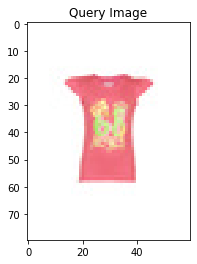

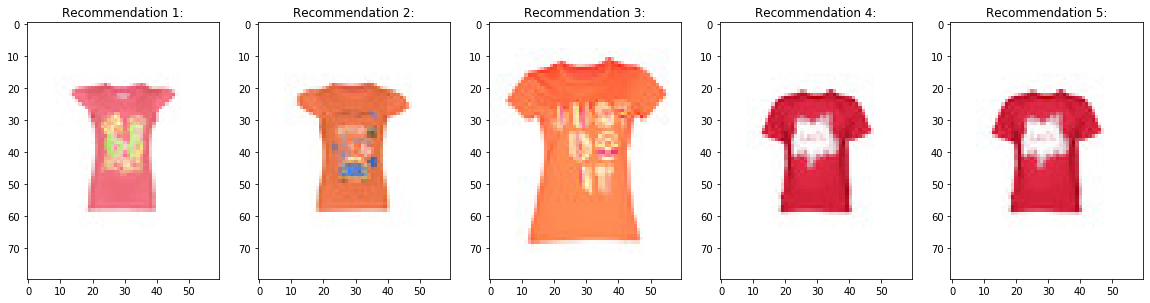

In [0]:
def getrecommendation(imagename, similaritydf):
  row= similaritydf.loc[imagename]
  indexes= np.argsort(row.values)[::-1][:5]
  images= [os.path.join('data', similaritydf.index[i]) for i in indexes]

  print(images)
  
  plt.figure()
  plt.imshow(plt.imread(os.path.join('data', imagename)))
  plt.title('Query Image')

  fig= plt.figure(figsize= (20, 5))
  for i in range(5):
    ax= fig.add_subplot(1, 5, i+1)
    ax.imshow(plt.imread(images[i]))
    ax.set_title('Recommendation {}:'.format(i+1))


getrecommendation('images/9998.jpg', df_sim)

['data/images/29024.jpg', 'data/images/33576.jpg', 'data/images/34198.jpg', 'data/images/16646.jpg', 'data/images/18991.jpg']


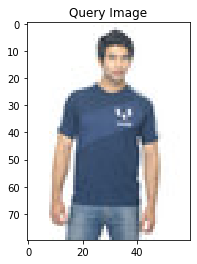

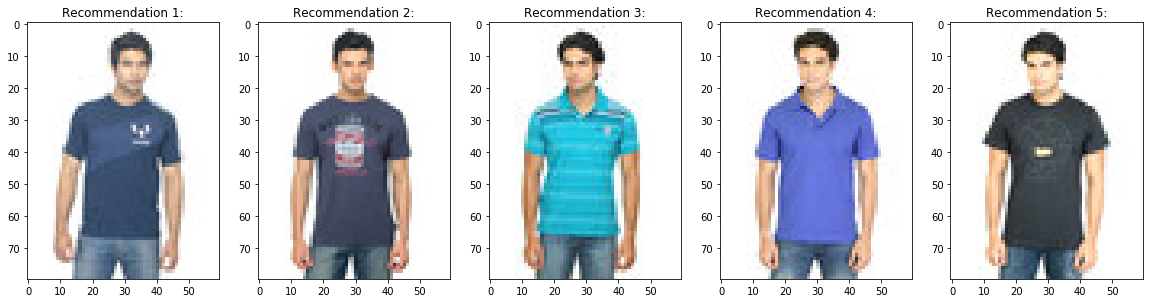

In [0]:
getrecommendationRandom(df_sim)

['data/images/17416.jpg', 'data/images/9330.jpg', 'data/images/22705.jpg', 'data/images/9399.jpg', 'data/images/54524.jpg']


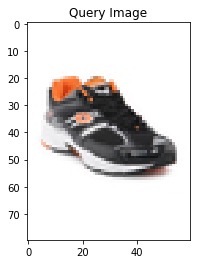

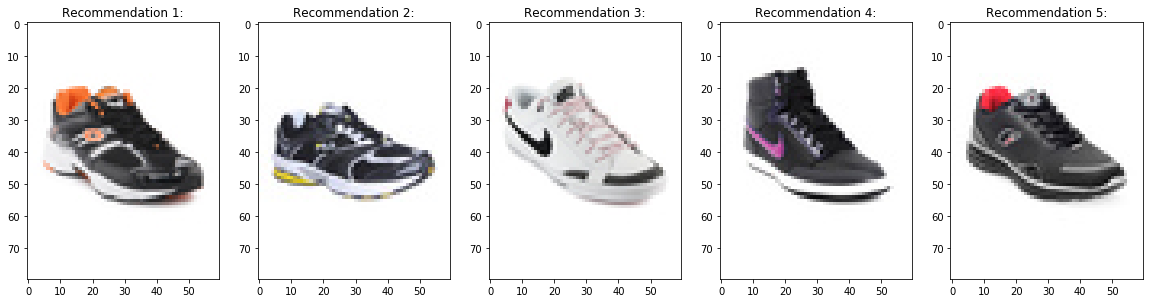

In [0]:
getrecommendationRandom(df_sim)

['data/images/57042.jpg', 'data/images/42216.jpg', 'data/images/5767.jpg', 'data/images/59987.jpg', 'data/images/41141.jpg']


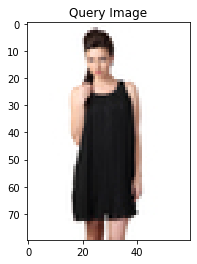

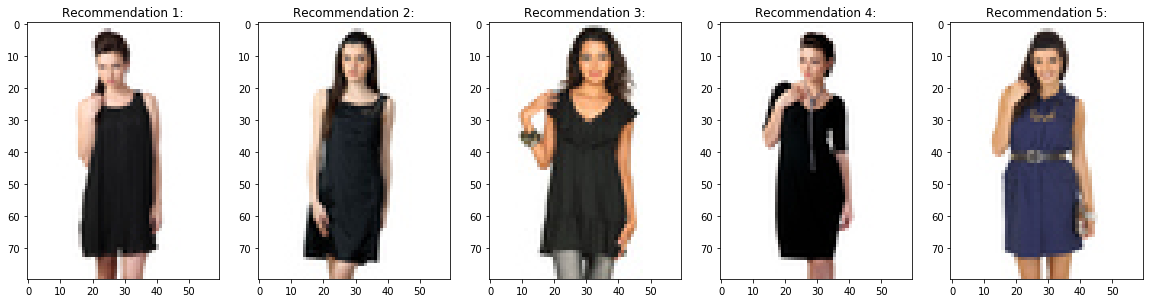

In [0]:
getrecommendationRandom(df_sim)

['data/images/51918.jpg', 'data/images/1939.jpg', 'data/images/27062.jpg', 'data/images/22005.jpg', 'data/images/10198.jpg']


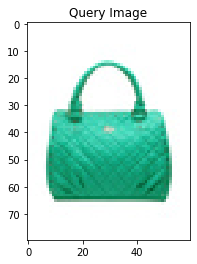

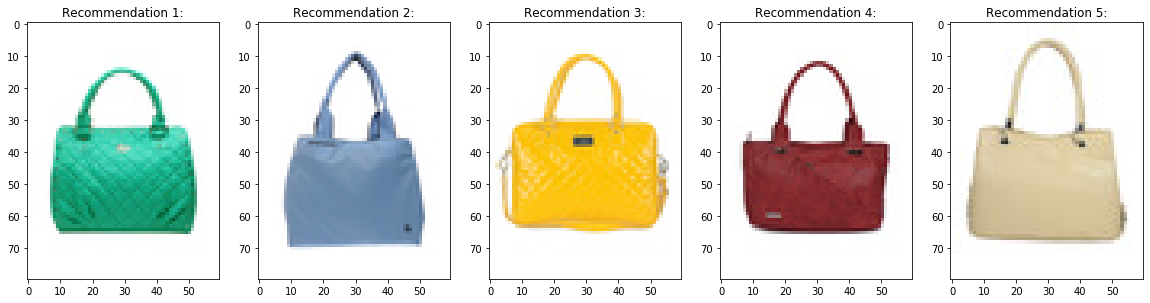

In [0]:
getrecommendationRandom(df_sim)

['data/images/27096.jpg', 'data/images/28722.jpg', 'data/images/32268.jpg', 'data/images/28688.jpg', 'data/images/11547.jpg']


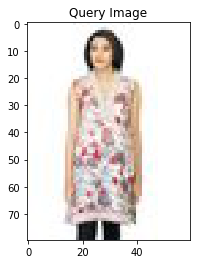

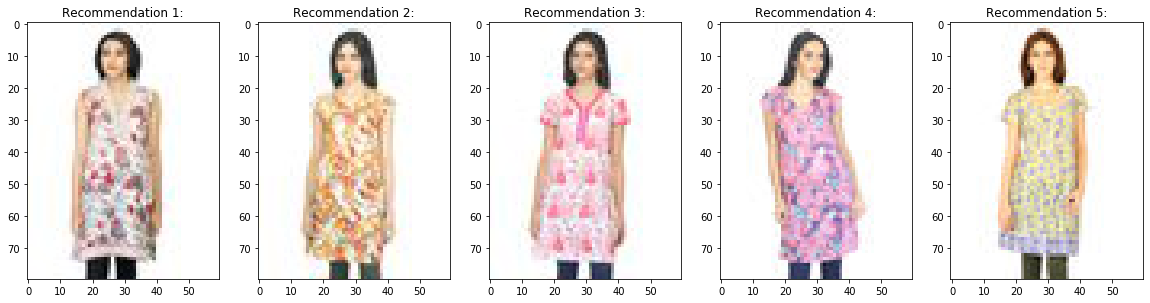

In [0]:
getrecommendationRandom(df_sim)

['data/images/57443.jpg', 'data/images/57428.jpg', 'data/images/26913.jpg', 'data/images/42390.jpg', 'data/images/53121.jpg']


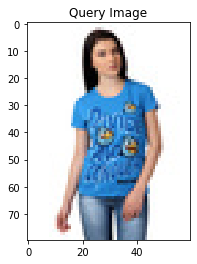

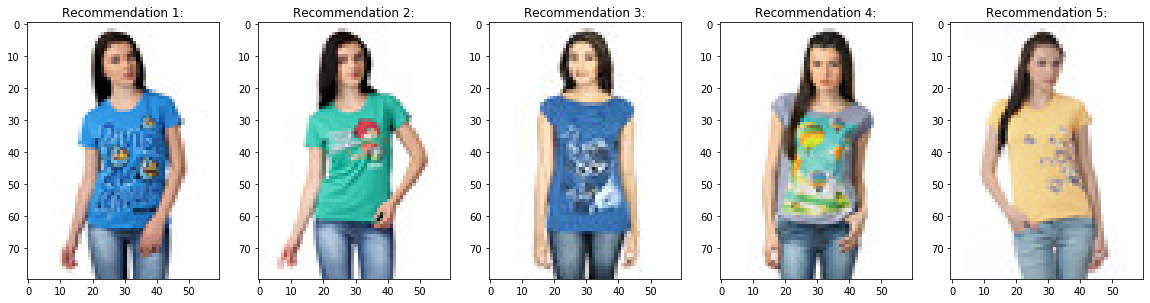

In [21]:
getrecommendationRandom(df_sim)

In [27]:
df_features.sample(4)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
images/4366.jpg,0.000000,0.474108,0.393000,0.030924,0.000000,0.305256,0.052705,0.526114,0.431287,0.574985,0.000000,0.0,0.109807,0.024478,0.069475,0.702133,0.023639,0.011977,0.003233,0.000000,0.000000,0.000000,0.000466,0.042091,0.21184,0.008161,0.000000,0.108655,0.005571,0.031462,0.003875,0.229217,0.000000,0.395739,0.000345,0.020647,0.464946,0.044263,0.008084,1.263152,...,0.473297,0.766794,0.054476,0.005294,0.099549,1.171553,0.000000,0.012854,0.094513,0.000000,0.000107,0.032444,0.000000,0.129517,0.437890,0.760506,0.004127,0.047005,0.486992,0.0,0.000856,0.006371,0.852551,0.382580,0.046627,0.000000,0.148150,0.000145,0.006392,1.053154,0.244154,0.00000,0.00030,0.027869,0.0,0.000000,0.027047,0.00000,0.026226,0.000656
images/39305.jpg,0.836272,0.000000,0.000000,0.000000,0.468949,0.788651,0.286227,0.317950,0.006429,0.000000,0.000000,0.0,0.012085,0.001905,0.854989,0.071453,0.167490,0.003946,0.000000,0.001302,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.007565,0.000000,0.365953,0.102550,0.152145,0.000000,0.000000,0.000000,0.291327,0.000000,1.087412,0.428910,0.457286,0.342159,...,0.000956,0.256400,0.296190,0.000000,0.000000,0.000000,0.012364,0.000000,0.002030,0.000000,0.000000,0.001230,0.000000,0.012440,0.000000,0.021940,0.000000,0.437811,0.000000,0.0,0.000000,0.100049,0.010727,0.016392,0.189212,0.000000,0.668024,0.000572,0.517649,0.255163,0.560439,0.00000,0.00000,0.000000,0.0,0.000000,0.051994,0.00000,0.000000,0.521693
images/38154.jpg,0.557190,0.020526,0.041437,0.000000,0.100760,0.109023,0.997807,0.326348,0.000000,0.000192,0.000000,0.0,0.229173,0.091070,0.088652,0.969556,0.000000,0.533616,0.000000,0.104502,0.006401,0.000000,0.000000,0.004929,0.00000,0.000000,0.436691,0.027974,0.001419,0.045411,0.098888,0.594505,0.002115,0.149996,0.043533,0.000000,0.517622,0.340361,0.035229,0.125702,...,0.516768,0.028520,0.362160,0.000000,0.682628,0.331136,0.000000,0.234608,0.237805,0.001724,0.000000,0.008758,0.012723,0.140738,0.116465,0.314212,0.024400,0.471402,0.000000,0.0,0.000000,0.112376,0.303003,0.639251,0.017856,0.480514,1.085033,0.000000,0.324454,0.094187,0.004830,0.02238,0.27682,0.000000,0.0,0.000000,0.037130,0.10244,0.004200,0.162344
images/3298.jpg,1.061364,0.228438,0.002420,0.000000,0.000000,0.017346,0.815855,0.025054,0.002113,0.000000,0.314989,0.0,0.765629,0.104214,1.257412,0.000000,0.000000,0.000000,0.000000,0.001350,0.100334,0.131016,0.000000,0.000000,0.00000,0.000000,0.000000,0.200451,0.000000,0.493267,0.008450,0.000000,0.000000,0.000000,0.320397,0.102394,0.240667,0.000000,0.033360,0.360583,...,0.517372,0.164115,0.187917,0.345976,0.001442,0.000000,0.908515,0.000000,0.054798,0.000000,0.000000,0.322027,0.000000,0.274737,0.000000,0.012917,0.000000,0.045985,0.000000,0.0,0.000000,0.176503,0.000000,0.014267,0.000000,0.002988,0.730979,0.006077,0.000000,0.057980,0.353375,0.00228,0.00000,0.000000,0.0,0.281282,0.020213,0.00000,0.000000,0.306531


[19188 32943 32941 27715 32939]


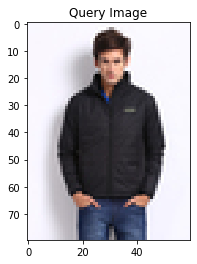

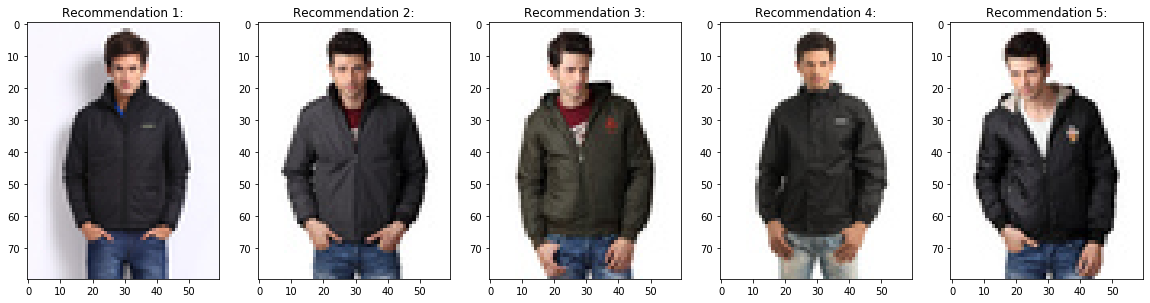

In [41]:
# Another idea is to compute cosine similarity at runtime
# features are already extracted in dataframe which we are going to use here
from scipy import spatial

def getrecommendation(filename):
  similarities= []
  features= df_features.loc[filename].values
  for i in range(len(df_features)):
    similarities.append(spatial.distance.cosine(df_features.iloc[i].values, features))

  indexes= np.argsort(similarities)[:5]
  print(indexes)
  images= [os.path.join('myntradataset', df_features.index[i]) for i in indexes]

  plt.figure()
  plt.imshow(plt.imread(os.path.join('myntradataset', filename)))
  plt.title('Query Image')

  fig= plt.figure(figsize= (20, 5))
  for i in range(5):
    ax= fig.add_subplot(1, 5, i+1)
    ax.imshow(plt.imread(images[i]))
    ax.set_title('Recommendation {}:'.format(i+1))

getrecommendation('images/38154.jpg')